<a href="https://colab.research.google.com/github/shairatabassum/MachineLearning_python/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Decision Tree Algorithm**

The Decision Tree builds a tree that splits the data such that we have the best separation of the classes. It is also the basis for the very popular random forest model.

For example, we want to predict if a person will **walk** or **take a bus** to go to work. There are 10 samples with 2 features: i) if it is raining or not, ii) how much time is left. So, the prediction or the class label is **Yes** or **No** which determines whether the person will walk or not.

Initially, decision tree will put all the samples to the root node. Then, it will apply a **question** such as **if it is raining**. If the answer is yes, we will go to the **right**, otherwise **left**. Now, on the **right** branch, the answer is **No**, so the person will not walk. On the **left**, it will ask **another question** such as **if they have more than 10 minutes**. Again, if the answer is **yes**, we will go to the **right**, and if the answer is **no**, we will go to the **left**. This process is continues until we reach a leaf node and conclude a final output.

We have to find out two things:
* What should be the questions?
* Which question should be asked on which node?

<br>

**Entropy:**

$ E = - $$\sum$$ p(X) \cdot log_2 (p(X)) $

$ p(X) = \frac{\#x}{n} $

**Information Gain:**

$ IG = E(parent) - [weighted average] \cdot E(children) $

<br>

## **Approach**
**Train algorithm := Build the tree**
* Start at the top node and at each node select the best split based on the best information gain.
* Greedy search: Loop over all features and over all thresholds (all possible feature values).
* Save the best split feature and split threshold at each node.
* Build the tree recursively. 
* Apply some stopping criteria to stop growing, such as: maximum depth, minimum samples at node, no more class distribution in node. 
* When we have a leaf node, store the most common class label of this node. 

**Predict := Traverse tree**
* Traverse the tree recursively. 
* At each node look at the best split feature of the test feature vector x and go left or right, depending on **x[feature_idx] <= threshold**.
* When we reach the leaf node, we return the stored most common class label.

### **Import Dataset**

In [16]:
# import libraries
import numpy as np
from collections import Counter
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import sklearn
from sklearn import tree

In [5]:
# load breast cancer dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# print data samples
print('X: ', X_train.shape)
print('Sample of X:', X_train[0])
print('y: ', y_train.shape)
print('Sample of y:', y_train[0])

X:  (455, 30)
Sample of X: [1.288e+01 1.822e+01 8.445e+01 4.931e+02 1.218e-01 1.661e-01 4.825e-02
 5.303e-02 1.709e-01 7.253e-02 4.426e-01 1.169e+00 3.176e+00 3.437e+01
 5.273e-03 2.329e-02 1.405e-02 1.244e-02 1.816e-02 3.299e-03 1.505e+01
 2.437e+01 9.931e+01 6.747e+02 1.456e-01 2.961e-01 1.246e-01 1.096e-01
 2.582e-01 8.893e-02]
y:  (455,)
Sample of y: 1


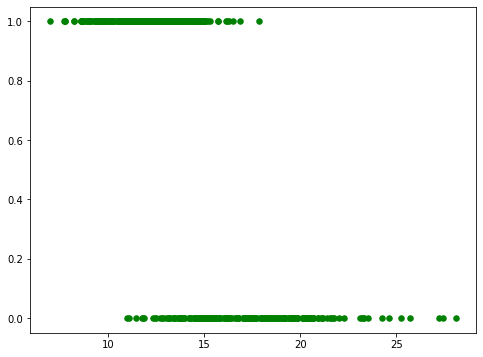

In [6]:
# plot data samples
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], y, color='g', s=30)
plt.show()

### **Decision Tree from scratch**

In [2]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [3]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [4]:
class DecisionTreeModel:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [11]:
# train the model
clf = DecisionTreeModel(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# model accuracy
accuracy = np.sum(y_test == predictions) / len(y_test)
print('Accuracy', round(accuracy*100, 2), '%')

Accuracy 93.86 %


In [12]:
# classification report
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       212
           1       0.98      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.99       569
weighted avg       0.99      0.99      0.99       569



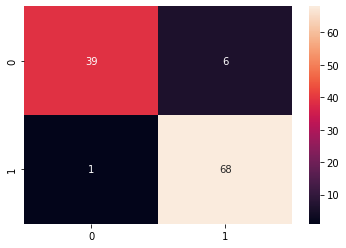

In [13]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)

### **Decision Tree using scikit-learn**

In [33]:
# train the model
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# model accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy = accuracy*100
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 89.47 %.


In [34]:
# classification report
print(classification_report(y, dt.predict(X)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       212
           1       0.98      0.99      0.98       357

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



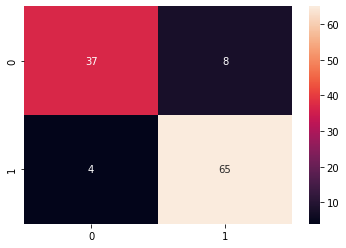

In [35]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

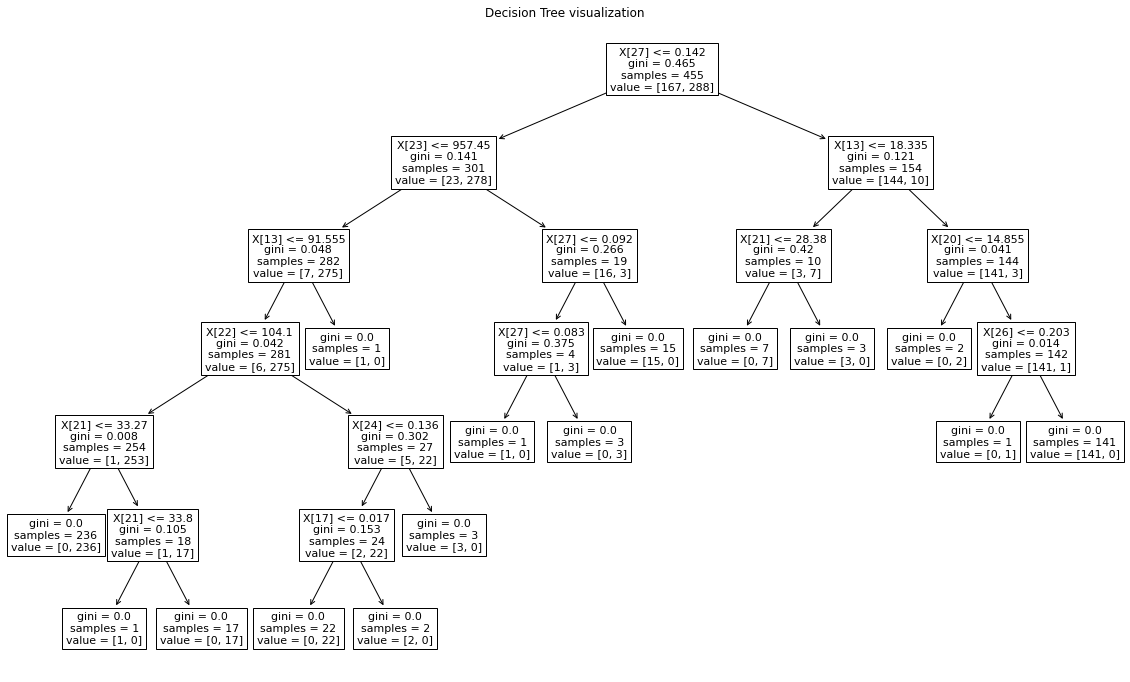

In [43]:
# plot tree
plt.figure(figsize=(20,12))
tree.plot_tree(dt, fontsize=11)
plt.title('Decision Tree visualization')
plt.show()